In [1]:
import gym
import time
import numpy as np
from PIL import Image
import pygame
import matplotlib.pyplot as plt
import random
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(list(gym.envs.registry.keys()))

['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4']


## RL Algos used:

- Q-learning

1. Initialize a Q-table with zeros
2. Use the Q-Learning formula to update Q-values:
```
Q[s,a] = Q[s,a] +  alpha * (R + gamma * np.max(Q[s', :]) - Q[s,a])
```
---
- Deep Q-Network
 
1. Define a policy nn to approximate the Q-function
2. Use the DQN algo with experience replay and a target network
3. Train the model using the Q-learning loss
```
L = MSE(Q(s,a), R + gamma * max(Q'(s',:)) * (1 - isDone))
```

# Helper functions

In [3]:
def test(agent, env, episodes=10, max_timesteps=200):
    pygame.init()
    clock = pygame.time.Clock()
    try:
        for e in range(episodes):
            state, info = env.reset()  # Reset the environment and get initial state
            total_reward = 0
            
            for t in range(max_timesteps): 
                # Choose the best action according to the trained agent 
                action = agent.act(state, test=True)
                
                # Take the action and observe the result
                next_state, reward, terminated, truncated, info = env.step(action)
                
                # Update the state and accumulate the reward
                state = next_state
                total_reward += reward
                
                # break when done
                if terminated or truncated:
                    break
    
                # render screen
                env.render()

                # pygame events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        return
                
                # add delay
                time.sleep(0.05)
                # frame rate
                clock.tick(15)
            
            print(f"Episode {e+1}/{episodes} finished with total reward: {total_reward}")
    finally:
        env.close()
        pygame.quit()

In [4]:
def moving_average(data, win_size=20):
    return np.convolve(data, np.ones(win_size) / win_size, mode='valid')

def visualize(rewards, win_size=20):
    rewards_ma = moving_average(rewards, win_size=win_size)
    plt.figure(figsize=(10,6))
    plt.plot(rewards, label='Rewards', color='blue', alpha=0.6)
    plt.plot(range(win_size-1, len(rewards)), rewards_ma, label=f"Moving Average (Window={win_size})", color='orange', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards and Moving Average over episodes')
    plt.legend()
    plt.show()

# Frozen Lake

## Method 1 : Q-Learning

The observation space: Discrete(16)
The action space: Discrete(4)


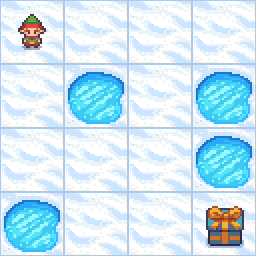

In [7]:
env = gym.make('FrozenLake-v1', render_mode="rgb_array")

# Observation and action space 
print(f"The observation space: {env.observation_space}") # state size
print(f"The action space: {env.action_space}") # Up / Down / Left / Right

# Display
obs = env.reset()
img = Image.fromarray(env.render())
img

In [75]:
class QAgent:
    def __init__(self, state_size, action_size,
                 gamma=0.95, alpha=0.3, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma
        self.qtable = np.zeros((state_size, action_size))
    
    def act(self, state, test=False):
        if not test:
            # Epsilon-greedy strategy
            if np.random.rand() <= self.epsilon:
                return random.randrange(self.action_size)
        return np.argmax(self.qtable[state])

    def update_q_values(self, state, action, reward, next_state):
        self.qtable[state, action] += self.alpha * ( reward + self.gamma * np.max(self.qtable[next_state, :]) - self.qtable[state, action])
        
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay     

In [16]:
def train(agent, env, episodes=800, max_timesteps=200, k=100):
    episode_rewards = []
    
    for e in range(episodes):
        state, info = env.reset()
        total_reward = 0
        
        for t in range(max_timesteps):     
            # Choose action
            action = agent.act(state)
            
            # Take the action and observe the result
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # update q_values
            agent.update_q_values(state, action, reward, next_state)
            
            # Update the state and accumulate the reward
            state = next_state
            total_reward += reward

            # end loop if done
            if done:
                break
                
        # Print ep metrics
        if (e + 1) % k == 0 or e == 0:
            print(f"Episode {e+1}/{episodes} | Epsilon {agent.epsilon:.2} | Mean Reward {sum(episode_rewards[-k:])/k}")
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Store the total reward for the episode
        episode_rewards.append(total_reward)
        
    return episode_rewards

In [84]:
env = gym.make('FrozenLake-v1', is_slippery=False) 
state_size = env.observation_space.n
action_size = env.action_space.n
agent = QAgent(state_size, action_size)

In [85]:
hist = train(agent, env, episodes=2000, max_timesteps=100)

Episode 1/2000 | Epsilon 1.0 | Mean Reward 0.0
Episode 100/2000 | Epsilon 0.61 | Mean Reward 0.07
Episode 200/2000 | Epsilon 0.37 | Mean Reward 0.41
Episode 300/2000 | Epsilon 0.22 | Mean Reward 0.68
Episode 400/2000 | Epsilon 0.14 | Mean Reward 0.88
Episode 500/2000 | Epsilon 0.082 | Mean Reward 0.85
Episode 600/2000 | Epsilon 0.05 | Mean Reward 0.97
Episode 700/2000 | Epsilon 0.03 | Mean Reward 0.95
Episode 800/2000 | Epsilon 0.018 | Mean Reward 0.99
Episode 900/2000 | Epsilon 0.011 | Mean Reward 0.97
Episode 1000/2000 | Epsilon 0.01 | Mean Reward 0.99
Episode 1100/2000 | Epsilon 0.01 | Mean Reward 1.0
Episode 1200/2000 | Epsilon 0.01 | Mean Reward 1.0
Episode 1300/2000 | Epsilon 0.01 | Mean Reward 0.99
Episode 1400/2000 | Epsilon 0.01 | Mean Reward 0.99
Episode 1500/2000 | Epsilon 0.01 | Mean Reward 0.98
Episode 1600/2000 | Epsilon 0.01 | Mean Reward 0.99
Episode 1700/2000 | Epsilon 0.01 | Mean Reward 1.0
Episode 1800/2000 | Epsilon 0.01 | Mean Reward 1.0
Episode 1900/2000 | Epsilon

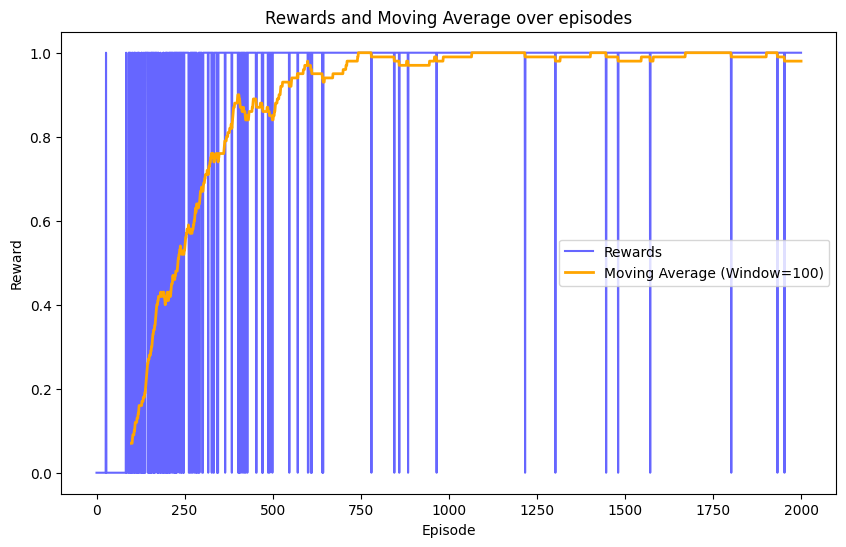

In [86]:
visualize(hist, win_size=100)

In [87]:
env = gym.make('FrozenLake-v1', render_mode="human", is_slippery=False)
test(agent, env)

Episode 1/10 finished with total reward: 1.0
Episode 2/10 finished with total reward: 1.0
Episode 3/10 finished with total reward: 1.0
Episode 4/10 finished with total reward: 1.0
Episode 5/10 finished with total reward: 1.0
Episode 6/10 finished with total reward: 1.0
Episode 7/10 finished with total reward: 1.0
Episode 8/10 finished with total reward: 1.0
Episode 9/10 finished with total reward: 1.0
Episode 10/10 finished with total reward: 1.0


## Method 2 : DQN 

The observation space: Discrete(64)
The action space: Discrete(4)


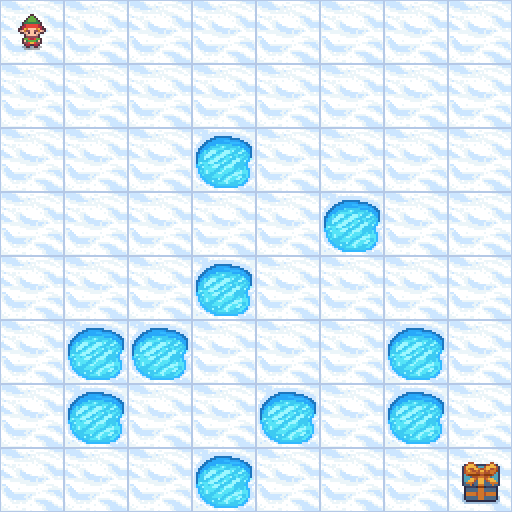

In [50]:
env = gym.make('FrozenLake8x8-v1', render_mode="rgb_array")

# Observation and action space 
print(f"The observation space: {env.observation_space}") # state size
print(f"The action space: {env.action_space}") # Up / Down / Left / Right

# Display
obs = env.reset()
img = Image.fromarray(env.render())
img

In [106]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 12)
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

class DQNAgent:
    def __init__(self, state_size, action_size,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99, batch_size=32, lr=5e-4, mem_size=5000):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.memory = deque(maxlen=mem_size)  # experience replay memory
        self.model = DQN(state_size, action_size).float()
        self.target_model = DQN(state_size, action_size).float()
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
    def act(self, state, test=False):
        if not test:
            # Epsilon-greedy strategy
            if np.random.rand() <= self.epsilon:
                return random.randrange(self.action_size)
        state = self._to_one_hot(state)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample a batch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.cat([self._to_one_hot(s) for s in states])
        next_states = torch.cat([self._to_one_hot(s) for s in next_states])
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Get current Q-values for each state/action pairs
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute Q-targets
        with torch.no_grad():
            target_q_values = self.target_model(next_states)
        next_q_values = target_q_values.max(1)[0]
        targets = rewards + (self.gamma * next_q_values * (1 - dones))
        
        
        # Loss function
        loss = nn.MSELoss()(current_q_values, targets)
        
        # Backpropagate and optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def _to_one_hot(self, state):
        """
        convert discrete state to one-hot
        """
        return F.one_hot(torch.tensor(state), num_classes=self.state_size).float().unsqueeze(0)
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def save_model(self, filepath='../models/dqn_frozenlake8x8_model.pth'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        torch.save(self.model.state_dict(), filepath)
        print(f"Model saved to {filepath}")
        
    def load_model(self, filepath='../models/frozenlake8x8_model.pth'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        self.model.load_state_dict(torch.load(filepath))
        self.model.eval()  # Set the model to evaluation mode
        print(f"Model loaded from {filepath}")

In [120]:
def train2(agent, env, episodes=800, max_timesteps=200, k=50, update_freq=10):
    episode_rewards = []
    
    for e in range(episodes):
        state, info = env.reset()
        total_reward = 0
        
        for t in range(max_timesteps):     
            # Choose action
            action = agent.act(state)
            
            # Take the action and observe the result
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Remember the experience
            agent.remember(state, action, reward, next_state, done)

            # Train the agent
            agent.replay()
            
            # Update the state and accumulate the reward
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        # print ep metrics
        if (e + 1) % k == 0 or e == 0:
            print(f"Episode {e+1}/{episodes} finished with epsilon {agent.epsilon:.2} and mean reward {sum(episode_rewards[-k:])/k}")
        
        # Update target model after 10 eps
        if e % update_freq == 0:
            agent.update_target_model()
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Store the total reward for the episode
        episode_rewards.append(total_reward)


    env.close()
    return episode_rewards

In [121]:
env = gym.make('FrozenLake8x8-v1', is_slippery=False) 
state_size = env.observation_space.n
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

In [122]:
hist = train2(agent, env, episodes=1500, max_timesteps=100)

Episode 1/1500 finished with epsilon 1.0 and mean reward 0.0
Episode 50/1500 finished with epsilon 0.78 and mean reward 0.0
Episode 100/1500 finished with epsilon 0.61 and mean reward 0.0
Episode 150/1500 finished with epsilon 0.47 and mean reward 0.15
Episode 200/1500 finished with epsilon 0.37 and mean reward 0.05
Episode 250/1500 finished with epsilon 0.29 and mean reward 0.3
Episode 300/1500 finished with epsilon 0.22 and mean reward 0.05
Episode 350/1500 finished with epsilon 0.17 and mean reward 0.05
Episode 400/1500 finished with epsilon 0.14 and mean reward 0.1
Episode 450/1500 finished with epsilon 0.11 and mean reward 0.65
Episode 500/1500 finished with epsilon 0.082 and mean reward 0.05
Episode 550/1500 finished with epsilon 0.064 and mean reward 0.05
Episode 600/1500 finished with epsilon 0.05 and mean reward 0.0
Episode 650/1500 finished with epsilon 0.039 and mean reward 0.35
Episode 700/1500 finished with epsilon 0.03 and mean reward 0.65
Episode 750/1500 finished with e

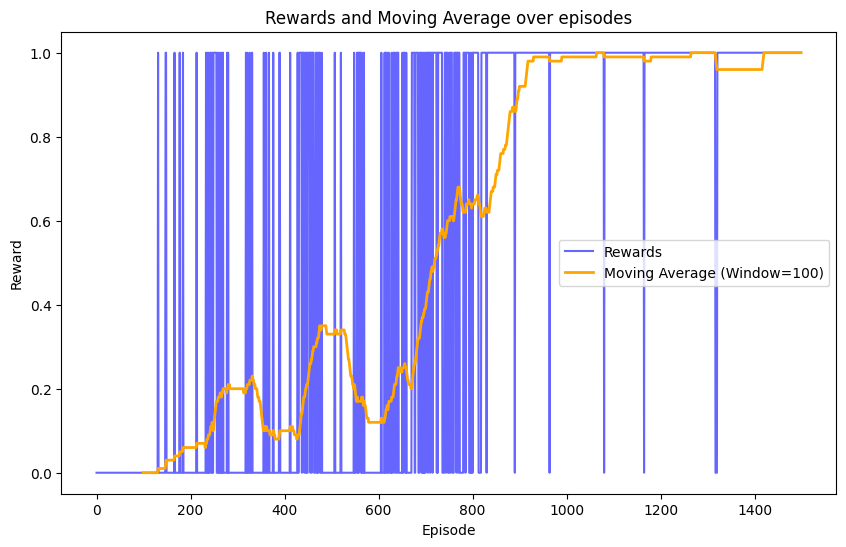

In [123]:
visualize(hist, win_size=100)

In [125]:
env = gym.make('FrozenLake8x8-v1', render_mode="human", is_slippery=False)
test(agent, env, episodes=10, max_timesteps=100)

Episode 1/10 finished with total reward: 1.0
Episode 2/10 finished with total reward: 1.0
Episode 3/10 finished with total reward: 1.0
Episode 4/10 finished with total reward: 1.0
Episode 5/10 finished with total reward: 1.0
Episode 6/10 finished with total reward: 1.0
Episode 7/10 finished with total reward: 1.0
Episode 8/10 finished with total reward: 1.0
Episode 9/10 finished with total reward: 1.0
Episode 10/10 finished with total reward: 1.0


In [124]:
agent.save_model()

Model saved to ../models/dqn_frozenlake8x8_model.pth


# Taxi-v3

The observation space: Discrete(500)
The action space: Discrete(6)


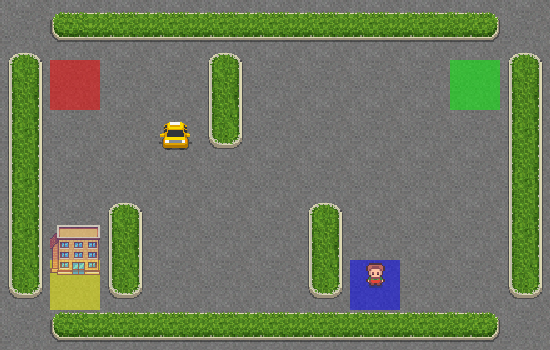

In [5]:
env = gym.make('Taxi-v3', render_mode="rgb_array")

# Observation and action space 
print(f"The observation space: {env.observation_space}") # state size
# 6 actions: up / down / left / right / pick-up / drop-off
print(f"The action space: {env.action_space}") 

# Display
obs = env.reset()
img = Image.fromarray(env.render())
img

In [6]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99, batch_size=64, lr=5e-4, mem_size=5000):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.memory = deque(maxlen=mem_size)  # experience replay memory
        self.model = DQN(state_size, action_size).float()
        self.target_model = DQN(state_size, action_size).float()
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
    def act(self, state, test=False):
        if not test:
            # Epsilon-greedy strategy
            if np.random.rand() <= self.epsilon:
                return random.randrange(self.action_size)
        state = self._to_one_hot(state)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample a batch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.cat([self._to_one_hot(s) for s in states])
        next_states = torch.cat([self._to_one_hot(s) for s in next_states])
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Get current Q-values
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute Q-targets
        with torch.no_grad():
            target_q_values = self.target_model(next_states)
        next_q_values = target_q_values.max(1)[0]
        targets = rewards + (self.gamma * next_q_values * (1 - dones))
        
        
        # Loss function
        loss = nn.MSELoss()(current_q_values, targets)
        
        # Backpropagate and optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def _to_one_hot(self, state):
        """
        convert discrete state to one-hot
        """
        return F.one_hot(torch.tensor(state), num_classes=self.state_size).float().unsqueeze(0)
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def save_model(self, filepath='../models/dqn_taxi_model.pth'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        torch.save(self.model.state_dict(), filepath)
        print(f"Model saved to {filepath}")
        
    def load_model(self, filepath='../models/dqn_taxi_model.pth'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        self.model.load_state_dict(torch.load(filepath))
        self.model.eval()  # Set the model to evaluation mode
        print(f"Model loaded from {filepath}")

In [10]:
env = gym.make('Taxi-v3')
state_size = env.observation_space.n
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

In [15]:
def train3(agent, env, episodes=1000, max_timesteps=200, k=50, update_freq=10):
    episode_rewards = []
    
    for e in range(episodes):
        state, info = env.reset()
        total_reward = 0
        
        for t in range(max_timesteps):     
            # Choose action
            action = agent.act(state)
            
            # Take the action and observe the result
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Remember the experience
            agent.remember(state, action, reward, next_state, done)

            # Train the agent
            agent.replay()
            
            # Update the state and accumulate the reward
            state = next_state
            total_reward += reward
            
            if done:
                break
                
        # print metrics
        if (e + 1) % k == 0 or e == 0:
            print(f"Episode {e+1}/{episodes} finished with epsilon {agent.epsilon:.2} and mean reward {sum(episode_rewards[-k:])/k}")
        
        # Update target model after 10 eps
        if e % update_freq == 0:
            agent.update_target_model()
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Store the total reward for the episode
        episode_rewards.append(total_reward)

    env.close()
    return episode_rewards

In [11]:
# Run the training
hist = train3(agent, env)

Episode 1/1000 finished with epsilon 1.0 and mean reward 0.0
Episode 50/1000 finished with epsilon 0.78 and mean reward -697.66
Episode 100/1000 finished with epsilon 0.61 and mean reward -539.34
Episode 150/1000 finished with epsilon 0.47 and mean reward -441.42
Episode 200/1000 finished with epsilon 0.37 and mean reward -304.38
Episode 250/1000 finished with epsilon 0.29 and mean reward -320.46
Episode 300/1000 finished with epsilon 0.22 and mean reward -228.22
Episode 350/1000 finished with epsilon 0.17 and mean reward -203.24
Episode 400/1000 finished with epsilon 0.14 and mean reward -129.74
Episode 450/1000 finished with epsilon 0.11 and mean reward -109.94
Episode 500/1000 finished with epsilon 0.082 and mean reward -56.7
Episode 550/1000 finished with epsilon 0.064 and mean reward -53.7
Episode 600/1000 finished with epsilon 0.05 and mean reward -26.72
Episode 650/1000 finished with epsilon 0.039 and mean reward -12.76
Episode 700/1000 finished with epsilon 0.03 and mean reward

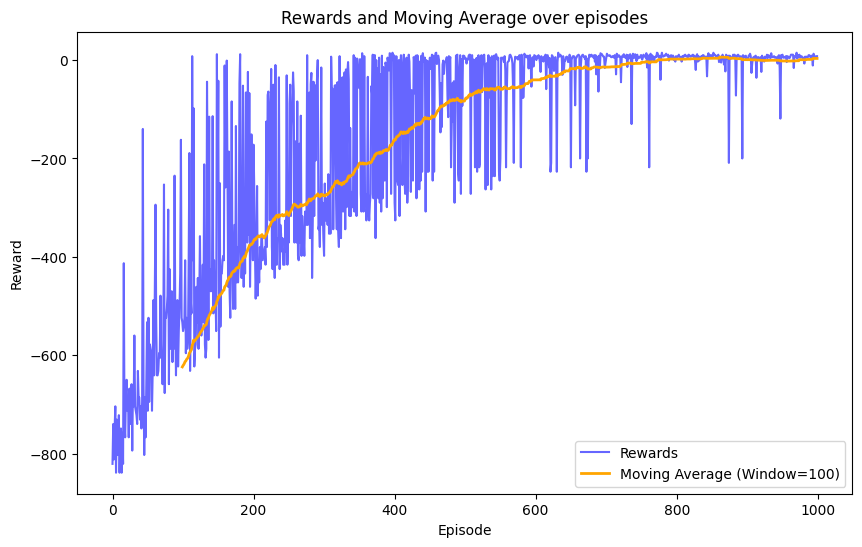

In [12]:
visualize(hist, win_size=100)

In [13]:
env = gym.make('Taxi-v3', render_mode="human")
test(agent, env)

Episode 1/10 finished with total reward: 9
Episode 2/10 finished with total reward: 10
Episode 3/10 finished with total reward: 5
Episode 4/10 finished with total reward: 6
Episode 5/10 finished with total reward: 6
Episode 6/10 finished with total reward: 9
Episode 7/10 finished with total reward: 10
Episode 8/10 finished with total reward: 10
Episode 9/10 finished with total reward: 12
Episode 10/10 finished with total reward: 5


In [14]:
agent.save_model()

Model saved to ../models/dqn_taxi_model.pth
